In [1]:
from pprint import pprint

from cobra.flux_analysis import flux_variability_analysis as fva, find_blocked_reactions

from gsmmutils import DATA_PATH
from gsmmutils.model.COBRAmodel import *
import matplotlib.pyplot as plt

In [67]:
model = MyModel(join(DATA_PATH, 'models/model_pl.xml'), 'e_Biomass__cytop')  #4085 -> 7398 -> 7023 -> 6919 -> 6862 -> 6674 -> 6578 -> 5823 -> 5622 -> 5511 -> 5117m
model.set_prism_reaction("PRISM_fluorescent_cool_215W__extr")

Loading

Reactions: 4770
Metabolites: 4215
Genes: 1350
Model loaded


In [22]:
from gsmmutils import get_biomass_mass


def get_element_in_biomass(model, element, biomass_reaction):
    res = get_biomass_mass(model, biomass_reaction,  lipid_subreactions = [model.reactions.e_TAG__lip,
                              model.reactions.e_DAG__er, model.reactions.e_DGTA__er, model.reactions.e_DGCC__er, model.reactions.e_DGGA__er, model.reactions.e_PE__cytop, model.reactions.e_PC__cytop,
                              model.reactions.e_PG__chlo, model.reactions.e_DGDG__chlo,
                              model.reactions.e_SQDG__chlo, model.reactions.e_MGDG__chlo, model.reactions.e_CL__mito,
                              model.reactions.e_FFA__cytop, model.reactions.e_CER__er])
    percentage_map = {}
    for key in res[1]:
        percentage_map[key] = res[1][key] * Metabolite(formula=key).formula_weight / 1000
    if round(sum(percentage_map.values()), 3) != 1: print(
        f"Error! Sum of Elemental mass percentage is different from 1! ({round(sum(percentage_map.values()), 3)})")
    return percentage_map[element]
    
get_element_in_biomass(model, "C", model.reactions.e_Biomass__cytop)

e_Pigment__chlo 0.04302
e_RNA__cytop 0.031
e_Carbohydrate__cytop 0.15124
e_Sterol__cytop 0.013
e_DNA__cytop 0.007
e_Cofactor__cytop 0.00958
e_Protein__cytop 0.48565
Error! Sum of Elemental mass percentage is different from 1! (1.007)


0.576434061314922

In [86]:
fva(model, ['ATP_Synthase__mitmem', 'R00081__mito', 'R02164__mito', 'R09504__mito', 'R11945__mitmem', 'Cytochrome_C_Reductase__mitmem', 'SOX__mito'], fraction_of_optimum=0.9)

,minimum,maximum
ATP_Synthase__mitmem,-63.460797,5.465368
R00081__mito,0.000000,9.520812
R02164__mito,0.000000,19.030667
R09504__mito,0.000000,6.947309
R11945__mitmem,0.000000,19.030667
Cytochrome_C_Reductase__mitmem,0.000000,19.044119
SOX__mito,0.000000,9.520812


In [188]:
from cobra.flux_analysis import pfba

with model:
    model.objective = "e_Biomass__cytop"
    model.exchanges.EX_C00205__dra.bounds = (-384, 1000)
    model.exchanges.EX_C00011__dra.bounds = (-35.04, 1000)
    sol = pfba(model)
    print(model.summary(sol))

Objective
1.0 e_Biomass__cytop = 0.13531697467297665

Uptake
------
  Metabolite       Reaction      Flux  C-Number C-Flux
C00001__extr EX_C00001__dra     4.167         0  0.00%
C00009__extr EX_C00009__dra   0.02316         0  0.00%
C00011__extr EX_C00011__dra     6.505         1 99.97%
C00059__extr EX_C00059__dra   0.02503         0  0.00%
C00080__extr EX_C00080__dra     1.651         0  0.00%
C00205__extr EX_C00205__dra       384         0  0.00%
C00244__extr EX_C00244__dra    0.9521         0  0.00%
C00305__extr EX_C00305__dra  0.003121         0  0.00%
C02823__extr EX_C02823__dra  3.57E-05        63  0.03%
C14818__extr EX_C14818__dra 0.0007331         0  0.00%

Secretion
---------
      Metabolite            Reaction       Flux  C-Number C-Flux
photon298__cytop DM_photon298__cytop    -0.0379         0  0.00%
  photon438__lum   DM_photon438__lum     -8.243         0  0.00%
 photon450__chlo  DM_photon450__chlo     -41.39         0  0.00%
 photon490__chlo  DM_photon490__chlo     -42.7

In [71]:
model.metabolites.C00080__extr.summary(sol)

Percent,Flux,Reaction,Definition
100.00%,16.01,EX_C00080__dra,C00080__extr <=>
Percent,Flux,Reaction,Definition
99.92%,-16,TO0019001t__plas,C00080__extr + C00267__extr --> C00080__cytop + C00267__cytop
0.08%,-0.01311,T_Fe2t__plas,C00080__extr + C14818__extr --> C00080__cytop + C14818__cytop


In [26]:
res = []
reaction_ids_no_comp = set(['__'.join(r.split("__")[:-1]) for r in model.reaction_ids if "cytop" not in r])
for reaction in model.reactions:
    if reaction.id.endswith("cytop") and not reaction.genes and {'__'.join(reaction.id.split("__")[:-1])}.issubset(reaction_ids_no_comp):
        res.append(reaction.id)
print(len(res))
pprint(res)

1
['R07316__cytop']


In [3]:
results_deeploc = pd.read_csv(r"C:\Users\Bisbii\OneDrive - Universidade do Minho\Algae\Models\Plutheri\result_plutheri.txt", sep="\t")
results_deeploc.head()

,ID,Location,Membrane,Nucleus,Cytoplasm,Extracellular,Mitochondrion,Cell_membrane,Endoplasmic_reticulum,Plastid,Golgi_apparatus,Lysosome/Vacuole,Peroxisome
0,KAG8468596.1,Cytoplasm,0.0472,0.0502,0.8116,0.0256,0.0002,0.0979,0.0010,0.0000,0.0002,0.0026,0.0107
1,KAG8459201.1,Cytoplasm,0.2025,0.1870,0.6747,0.0023,0.0003,0.1298,0.0007,0.0000,0.0004,0.0001,0.0045
2,KAG8458717.1,Mitochondrion,0.7063,0.1640,0.1341,0.0013,0.4194,0.0468,0.0001,0.0001,0.0000,0.0000,0.2342
3,KAG8461013.1,Cytoplasm,0.1055,0.1201,0.8103,0.0004,0.0005,0.0574,0.0002,0.0000,0.0003,0.0002,0.0105
4,KAG8466010.1,Cytoplasm,0.0676,0.0989,0.8392,0.0007,0.0005,0.0400,0.0004,0.0000,0.0003,0.0003,0.0196


In [4]:
genes_to_test = set()
extracellular_reactions = [reaction for reaction in model.reactions if reaction.id.endswith("__extr")]
for reaction in extracellular_reactions:
    if reaction.genes:
        for gene in reaction.genes:
            deep_loc_comp = results_deeploc.loc[results_deeploc["ID"] == gene.id.replace("_", "."), "Location"].values
            if deep_loc_comp and deep_loc_comp == "Peroxisome":
                print(reaction.id, deep_loc_comp, reaction.annotation['ec-code'])
                genes_to_test.add(gene.id.replace("_", "."))

BMGR6571__extr ['Peroxisome'] 2.3.1.20
BMGR6525__extr ['Peroxisome'] 2.3.1.20
BMGR1619__extr ['Peroxisome'] 2.3.1.20
R10561__extr ['Peroxisome'] 4.1.1.99
BMGR6534__extr ['Peroxisome'] 2.3.1.20
BMGR6602__extr ['Peroxisome'] 2.3.1.20
BMGR3560__extr ['Peroxisome'] 2.3.1.20
BMGR1963__extr ['Peroxisome'] 2.3.1.20
BMGR6562__extr ['Peroxisome'] 2.3.1.20
BMGR1990__extr ['Peroxisome'] 2.3.1.20
BMGR1926__extr ['Peroxisome'] 2.3.1.20
BMGR6580__extr ['Peroxisome'] 2.3.1.20
BMGR6516__extr ['Peroxisome'] 2.3.1.20
BMGR1944__extr ['Peroxisome'] 2.3.1.20
R02558__extr ['Peroxisome'] 3.2.1.21
R02558__extr ['Peroxisome'] 3.2.1.21
BMGR6552__extr ['Peroxisome'] 2.3.1.20
BMGR6590__extr ['Peroxisome'] 2.3.1.20
BMGR1925__extr ['Peroxisome'] 2.3.1.20
BMGR1866__extr ['Peroxisome'] 2.3.1.20
BMGR6553__extr ['Peroxisome'] 2.3.1.20
BMGR6599__extr ['Peroxisome'] 2.3.1.20
R09735__extr ['Peroxisome'] 2.10.1.1
BMGR6526__extr ['Peroxisome'] 2.3.1.20
BMGR1999__extr ['Peroxisome'] 2.3.1.20
R09726__extr ['Peroxisome'] 2.7.7

In [5]:
from Bio import SeqIO

fasta_file = SeqIO.parse(r"C:\Users\Bisbii\OneDrive - Universidade do Minho\Algae\Models\Plutheri\blast\plutheri_2686093_protein.faa", "fasta")
to_save = []
for gene in fasta_file:
    if gene.id in genes_to_test:
        to_save.append(gene)
SeqIO.write(to_save, r"C:\Users\Bisbii\OneDrive - Universidade do Minho\Algae\Models\Plutheri\plutheri_2686093_protein_peroxisome.faa", "fasta")

21

In [526]:
model.genes.get_by_id("KAG8462982" + "_1").reactions

frozenset({<Reaction BMGR1619__er at 0x18856b525f0>,
           <Reaction BMGR1619__extr at 0x18854a35b70>,
           <Reaction BMGR1623__er at 0x18854cfd6f0>,
           <Reaction BMGR1623__extr at 0x188562bdb70>,
           <Reaction BMGR1624__er at 0x188558ba230>,
           <Reaction BMGR1624__extr at 0x18855777490>,
           <Reaction BMGR1677__er at 0x1885608f7c0>,
           <Reaction BMGR1677__extr at 0x1885512fac0>,
           <Reaction BMGR1689__er at 0x18855c65f00>,
           <Reaction BMGR1689__extr at 0x18856267ac0>,
           <Reaction BMGR1694__er at 0x18854cdf250>,
           <Reaction BMGR1694__extr at 0x18854e43be0>,
           <Reaction BMGR1695__er at 0x188562edc60>,
           <Reaction BMGR1695__extr at 0x188551c2890>,
           <Reaction BMGR1709__er at 0x1885623ed70>,
           <Reaction BMGR1709__extr at 0x1885608e2f0>,
           <Reaction BMGR1710__er at 0x1885512dab0>,
           <Reaction BMGR1710__extr at 0x18855a48700>,
           <Reaction BMGR171

In [524]:
results_deeploc.loc[results_deeploc["ID"] == "KAG8462032.1", "Location"]

7787    Peroxisome
Name: Location, dtype: object

In [48]:
model.test_reaction("TO0000009_plasmem__plasmem")

,Flux,ReactantOrProduct
Orthophosphate,1000.0,Reactant
Orthophosphate,1000.0,Product


In [43]:
# model.create_sink("C00002__cytop")
# model.create_demand("C00015__cytop")
model.test_reaction("e_Biomass__cytop")

,Flux,ReactantOrProduct
e-Pigment,0.000000,Reactant
H2O,1990.220500,Reactant
e-RNA,0.000000,Reactant
e-Carbohydrate,0.000000,Reactant
e-Lipid,0.000000,Reactant
ATP,0.000000,Reactant
e-Sterol,0.000000,Reactant
e-DNA,0.000000,Reactant
e-Cofactor,0.000000,Reactant
e-Protein,0.000000,Reactant


In [53]:
ga = pd.read_excel(r"C:\Users\Bisbii\Desktop\homologyData_plutheri_validation_all_13_29_134.xlsx")
ga.fillna("", inplace=True)
ga.head()

C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,gene,status,name,product,score,EC number(s),score.1,notes
0,KAG8456883.1,\tunavailable,,Kinesin heavy chain,0.12,,,
1,,,,,,,,
2,,,,Kinesin-like protein klp-20,0.06,,,
3,,,,Kinesin-like protein Klp61F,0.06,,,
4,,,,Kinesin-II 85 kDa subunit,0.06,,,


In [62]:
transport_keywords = ["transport", "permease", "carrier", "channel", "porin", "symporter", "antiporter", "uniporter", "symport", "antiport", "uniport", "transporter"]
transport_rows = ga.loc[(ga["product"].str.contains("|".join(transport_keywords), case=False)) & (ga["product"] != "Acyl carrier protein")]
transport_rows.head()

,gene,status,name,product,score,EC number(s),score.1,notes
57,,,,MFS family transporter: multidrug efflux,0.07,,,
540,KAG8456989.1,\tunavailable,,Intraflagellar transport protein 74 homolog,0.29,,,
542,,,,Intraflagellar transport protein 74,0.29,,,
720,KAG8457029.1,\tunavailable,,Probable phospholipid-transporting ATPase IIB,0.15,7.6.2.1,0.56,E
722,,,,Phospholipid-transporting ATPase 2,0.06,,,


In [75]:
genes = set(transport_rows["gene"].tolist())
to_evaluate = genes - set([gene.id.replace("_", ".") for gene in model.genes]) - {""}

In [76]:
ga.loc[ga["gene"].isin(to_evaluate), ["gene", "product"]]

,gene,product
540,KAG8456989.1,Intraflagellar transport protein 74 homolog
1390,KAG8457177.1,Intraflagellar transport protein 81 homolog
1909,KAG8457287.1,Probable folate-biopterin transporter 2
1950,KAG8457299.1,Solute carrier family 25 member 40
2282,KAG8457351.1,Vacuolar transporter chaperone 2
...,...,...
71522,KAG8470566.1,Magnesium transporter NIPA3
72970,KAG8470834.1,Nucleoporin SEH1
73090,KAG8470851.1,Phospholipid-transporting ATPase IC
73557,KAG8470929.1,Voltage-dependent L-type calcium channel subun...


In [42]:
model = MyModel(join(DATA_PATH, 'models/model_pl.xml'), 'e_Biomass__cytop')  #5585
exchanges = ['EX_C02823__dra',
             'EX_C14818__dra',
             'EX_C00080__dra',
             'EX_C00038__dra',
             'EX_C00001__dra',
             'EX_C00059__dra',
             'EX_C00244__dra',
             'EX_C00011__dra',
             'EX_C00305__dra',
             'EX_C00007__dra',
             'EX_C01330__dra',
             'EX_C00076__dra',
             'EX_C19610__dra',
             'EX_C00238__dra',
             'EX_C00205__dra', 
             'EX_C00009__dra']
for exchange in exchanges:
    model.reactions.get_by_id(exchange).lower_bound = -1000
    model.reactions.get_by_id(exchange).upper_bound = 1000
model.reactions.ATPm__cytop.bounds = (0, 1000)
model.slim_optimize()
# blocked = find_blocked_reactions(model, open_exchanges=True, processes=6)
# print(len(blocked) / len(model.reactions))  # 0.2070

Loading

Reactions: 4804
Metabolites: 4221
Genes: 1328
Model loaded


0.9202056750346769

In [275]:
model_ng = MyModel(join(DATA_PATH, 'models/model_ng.xml'), 'e_Biomass__cytop')
# model_ds = MyModel(join(DATA_PATH, 'models/model_ds.xml'), 'e_Biomass__cytop')
# model_pl = MyModel(join(DATA_PATH, 'models/model_pl.xml'), 'e_Biomass__cytop')

Loading

Reactions: 4557
Metabolites: 3854
Genes: 1332
Model loaded


In [221]:
for met in model_ng.metabolites:
    if met.name.endswith("-sn-glycero-3-phosphate") and not met.name.startswith("CDP") and met.id.endswith("chlo") and "galactosyl" not in met.name and "sulfo" not in met.name and met.name.startswith("1-") and "2-" not in met.name:
        has_pa = False
        for reaction in met.reactions:
            if reaction.annotation.get("ec-code", "") == "2.3.1.15":
                has_pa = True
        if not has_pa:
            print(met.id, met.name)

In [276]:
blocked  = find_blocked_reactions(model_ng, open_exchanges=True, processes=6)

In [280]:
check_balance(model_ng)

{'SK_C03021__er': {'C': -5.0, 'H': -7.0, 'N': -3.0, 'O': -3.0, 'An': -2.0}}

In [278]:
model_ng.test_reaction("BMGR5932__chlo") 

,Flux,ReactantOrProduct
2-hexadecanoyl-sn-glycero-3-phospho-(1'-sn-glycerol),4.545455e-02,Reactant
Palmitoyl-CoA,1.900000e-02,Reactant
CoA,1.226849e-07,Product
"1,2-dihexadecanoyl-sn-glycero-3-phospho-(1'-sn-glycerol)",1.107399e-04,Product


In [279]:
fva(model_ng, ['BMGR5932__chlo'], fraction_of_optimum=0.0)

,minimum,maximum
BMGR5932__chlo,0.0,0.0


In [186]:
check_balance(model_ds)

{'SK_C03021__chlo': {'C': -5.0, 'H': -7.0, 'N': -3.0, 'O': -3.0, 'An': -2.0},
 'BMGR0542__chlo': {'H': 1.0}}

In [438]:
fva(model_ng, ['R00093__mito'], fraction_of_optimum=0.0)

,minimum,maximum
R00093__mito,0.0,11.00294


In [435]:
model_ds.summary()

Running pFBA


Metabolite,Reaction,Flux,C-Number,C-Flux
C00001__extr,EX_C00001__dra,6.569,0,0.00%
C00009__extr,EX_C00009__dra,0.03078,0,0.00%
C00011__extr,EX_C00011__dra,8,1,99.91%
C00059__extr,EX_C00059__dra,0.02176,0,0.00%
C00080__extr,EX_C00080__dra,0.05323,0,0.00%
C00205__extr,EX_C00205__dra,69.9,0,0.00%
C00244__extr,EX_C00244__dra,0.507,0,0.00%
C00305__extr,EX_C00305__dra,0.0002088,0,0.00%
C02823__extr,EX_C02823__dra,0.0001183,63,0.09%
C14818__extr,EX_C14818__dra,0.002429,0,0.00%


In [286]:
counter = 0
for reaction in model_ds.reactions:
    if not reaction.id.endswith("mem") and not reaction.genes and "EX_" not in reaction.id and not reaction.id.startswith("e_") and not reaction.id.startswith("T_") and not reaction.id.startswith("DM_")  and not reaction.id.startswith("PRISM_")  and reaction.id.startswith("BMGR"): #
        print(reaction.id, reaction.name + "\n" + "#"*140)
        counter += 1
counter

0

In [327]:
[(e.id, e.name) for e in model_ds.reactions.e_PC__cytop.reactants if 'hexadecadienoyl' in e.name]

[('BMGC39520__cytop',
  '1-(9Z-octadecenoyl)-2-(9Z,12Z-hexadecadienoyl)-sn-glycero-3-phosphocholine'),
 ('BMGC37099__cytop',
  '1-(9Z,12Z-hexadecadienoyl)-2-(9Z,12Z,15Z-octadecatrienoyl)-sn-glycero-3-phosphocholine')]

In [306]:
model_ds.test_reaction("BMGR6990__cytop")

,Flux,ReactantOrProduct
"1-(9Z,12Z-hexadecadienoyl)-sn-glycero-3-phosphocholine",0.333333,Reactant
H2O,1228.396043,Reactant
"(9Z,12Z)-hexadeca-9,12-dienoate",0.000000,Product
sn-Glycero-3-phosphocholine,1000.151837,Product
H+,2398.560171,Product


In [297]:
blocked = find_blocked_reactions(model_ds, open_exchanges=True, processes=6)

In [298]:
for r in blocked:
    if r.startswith("BMGR"):
        print(r)

BMGR6120__mito
BMGR0956__er
BMGR3341__chlo
BMGR1149__er
BMGR6116__mito
BMGR3240__cytop
BMGR0026__er
BMGR0422__er
BMGR6071__er
BMGR4444__chlomem
BMGR6065__er
BMGR0434__er
BMGR1142__er
BMGR4381__chlomem
BMGR6069__er
BMGR6117__mito
BMGR1105__er
BMGR0957__er
BMGR6061__er
BMGR6070__er
BMGR3242__cytop
BMGR3321__chlo
BMGR2713__er
BMGR1143__er
BMGR1054__er
BMGR6064__er
BMGR1048__er
BMGR0950__er
BMGR6115__mito
BMGR1286__er
BMGR6119__mito
BMGR6068__er
BMGR6113__mito
BMGR0018__er
BMGR1050__er
BMGR6111__mito
BMGR1104__er
BMGR6109__mito
BMGR0958__er
BMGR0420__er
BMGR6118__mito
BMGR0436__er
BMGR4496__chlomem
BMGR3320__chlo
BMGR1275__er
BMGR1055__er
BMGR6063__er
BMGR4379__chlomem
BMGR0406__er
BMGR1098__er
BMGR6990__cytop
BMGR3237__cytop
BMGR4760__ermem
BMGR6067__er
BMGR6112__mito
BMGR2921__chlo
BMGR5868__cytop
BMGR1148__er
BMGR0951__er
BMGR1103__er
BMGR6110__mito
BMGR1278__er
BMGR6114__mito
BMGR6062__er
BMGR1056__er
BMGR1097__er
BMGR3241__cytop
BMGR0057__er
BMGR1150__er
BMGR6066__er


In [287]:
counter = 0
for reaction in model_ng.reactions:
    if reaction.id in model_ds.reaction_ids:
        if model_ng.reactions_pathways_map[reaction.id] != model_ds.reactions_pathways_map[reaction.id] and reaction.id.startswith("BMGR"): # 
            print(reaction.id, model_ng.reactions_pathways_map[reaction.id], model_ds.reactions_pathways_map[reaction.id])
            counter += 1
print(counter)
counter = 0
for reaction in model_pl.reactions:
    if reaction.id in model_ds.reaction_ids:
        if model_pl.reactions_pathways_map[reaction.id] != model_ds.reactions_pathways_map[reaction.id] and reaction.id.startswith("BMGR"): # 
            print(reaction.id, model_pl.reactions_pathways_map[reaction.id], model_ds.reactions_pathways_map[reaction.id])
            counter += 1
print(counter)

counter = 0
for reaction in model_ds.reactions:
    if reaction.id in model_ng.reaction_ids:
        if model_ng.reactions_pathways_map[reaction.id] != model_ds.reactions_pathways_map[reaction.id] and reaction.id.startswith("BMGR"):  # 
            print(reaction.id, model_ng.reactions_pathways_map[reaction.id], model_ds.reactions_pathways_map[reaction.id])
            counter += 1
print(counter)
counter = 0
for reaction in model_ds.reactions:
    if reaction.id in model_pl.reaction_ids:
        if model_pl.reactions_pathways_map[reaction.id] != model_ds.reactions_pathways_map[reaction.id] and reaction.id.startswith("BMGR"):  # 
            print(reaction.id, model_pl.reactions_pathways_map[reaction.id], model_ds.reactions_pathways_map[reaction.id])
            counter += 1
counter

0
0
0


0

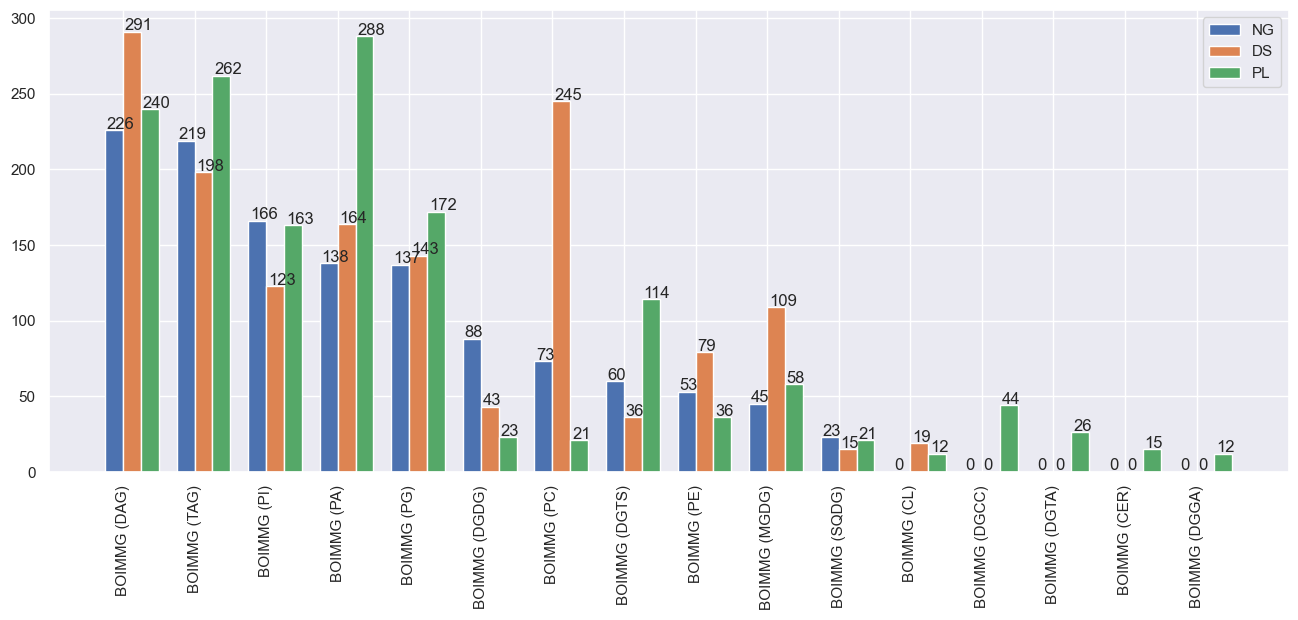

In [289]:
lipids_ng = {k: len(v) for k, v in model_ng.pathway_reactions_map.items() if k.startswith("BOIMMG")}
lipids_ds = {k: len(v) for k, v in model_ds.pathway_reactions_map.items() if k.startswith("BOIMMG")}
lipids_pl = {k: len(v) for k, v in model_pl.pathway_reactions_map.items() if k.startswith("BOIMMG")}
lipids = {k: (lipids_ng.get(k, 0), lipids_ds.get(k, 0), lipids_pl.get(k, 0)) for k in set(lipids_ng.keys()).union(set(lipids_ds.keys())).union(set(lipids_pl.keys()))}
from collections import OrderedDict
ordered_dict = OrderedDict(sorted(lipids.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(16, 6))
width = 0.25
x = range(len(ordered_dict))
plt.bar(x, [v[0] for v in ordered_dict.values()], width, label="NG")
plt.bar([i + width for i in x], [v[1] for v in ordered_dict.values()], width, label="DS")
plt.bar([i + width * 2 for i in x], [v[2] for v in ordered_dict.values()], width, label="PL")
plt.xticks([i + width / 2 for i in x], ordered_dict.keys(), rotation=90)
plt.legend()
# annoate each bar
for i, v in enumerate(ordered_dict.values()):
    plt.text(i - 0.1, v[0] + 1, str(v[0]))
    plt.text(i + width - 0.1, v[1] + 1, str(v[1]))
    plt.text(i + width * 2 - 0.1, v[2] + 1, str(v[2]))
plt.show()

In [7]:
for reaction in model_ds.reactions:
    if reaction.annotation.get("ec-code", "") == "2.3.1.51" and model_ds.reactions_pathways_map[reaction.id] != ['BOIMMG (PA)']:
        print(reaction.id, model_ds.reactions_pathways_map[reaction.id])

BMGR6120__mito ['Glycerophospholipid metabolism']
BMGR1488__chlo ['BOIMMG (PI)']
BMGR6116__mito ['Glycerophospholipid metabolism']
BMGR0211__chlo ['Glycerophospholipid metabolism']
BMGR5257__er ['BOIMMG (PG)', 'BOIMMG (DAG)']
BMGR6117__mito ['Glycerophospholipid metabolism']
BMGR1486__er ['BOIMMG (PI)']
BMGR0904__chlo ['BOIMMG (PG)']
BMGR5438__er ['BOIMMG (PG)', 'BOIMMG (DAG)']
BMGR5265__er ['BOIMMG (PG)', 'BOIMMG (DAG)']
BMGR3608__er ['BOIMMG (PG)', 'BOIMMG (DAG)']
BMGR1486__chlo ['BOIMMG (PI)']
BMGR3325__er ['BOIMMG (DAG)']
BMGR5211__er ['BOIMMG (PG)', 'BOIMMG (DAG)']
BMGR5262__er ['BOIMMG (PG)', 'BOIMMG (DAG)']
BMGR6115__mito ['Glycerophospholipid metabolism']
BMGR6119__mito ['Glycerophospholipid metabolism']
BMGR3610__er ['BOIMMG (PG)', 'BOIMMG (DAG)']
BMGR3344__er ['BOIMMG (DAG)']
BMGR5447__er ['BOIMMG (PG)', 'BOIMMG (DAG)']
BMGR0209__chlo ['Glycerophospholipid metabolism']
BMGR6118__mito ['Glycerophospholipid metabolism']
BMGR3615__er ['BOIMMG (PG)', 'BOIMMG (DAG)']
BMGR1488__er 

In [260]:
model_ng.test_reaction("FACOAL200__er")

,Flux,ReactantOrProduct
CoA,0.047619,Reactant
Icosanoic acid,0.000000,Reactant
ATP,0.000000,Reactant
Diphosphate,7.723363,Product
H+,32.568232,Product
AMP,0.000000,Product
Eicosanoyl-CoA,0.000000,Product


In [226]:
fva(model_ng, ["R00945__mito"], fraction_of_optimum=0.0)

,minimum,maximum
R00945__mito,-0.418838,2.605459


In [8]:
from gsmmutils.model.model_validator import ModelValidator

validator = ModelValidator(model)
validator.check_balance()

Mass balance: NOT OK
R01333__mito {'H': -1.0}


{'R01333__mito': {'H': -1.0}}

In [105]:
model_ng.test_reaction("BMGR6278__chlo")

,Flux,ReactantOrProduct
H2O,1852.540711,Reactant
"1-(9Z,12Z-octadecadienoyl)-2-(6Z,9Z,12Z-hexadecatrienoyl)-sn-glycero-3-phosphate",0.000000,Reactant
Orthophosphate,82.273738,Product
"1-(9Z,12Z-octadecadienoyl)-2-(6Z,9Z,12Z-hexadecatrienoyl)-sn-glycerol",0.000000,Product


In [383]:
# for gene in model_ds.genes:
#     to_print = False
#     for reaction in gene.reactions:
#         if 'ec-code' in reaction.annotation and reaction.annotation['ec-code'] == '2.3.1.158':
#             if reaction.id.endswith("chlo"):
#                 print(reaction.id.split("__")[0])
#             to_print= True
    # if to_print:
    #     print(gene.id)

Fuck, this tag is not in the chloroplast: BMGC223029__lip
Fuck, this tag is not in the chloroplast: BMGC172238__lip
1,2-di-(9Z-octadecenoyl)-3-(6Z,9Z,12Z-octadecatrienoyl)-sn-glycerol frozenset({<Reaction BMGR4411__chlomem at 0x164482ef040>, <Reaction BMGR1998__chlo at 0x164486028f0>})
1,2,3-tri-(9Z-hexadecenoyl)-sn-glycerol frozenset({<Reaction BMGR1712__chlo at 0x16447b55d20>, <Reaction BMGR4709__chlomem at 0x164488c3a60>})
Fuck, this tag is not in the chloroplast: BMGC215189__lip
Fuck, this tag is not in the chloroplast: tag1839Z12Z15Z164Z7Z12Z15Z1839Z12Z15Z__lip
Fuck, this tag is not in the chloroplast: BMGC161268__lip
1-hexadecanoyl-2,3-di-(9Z-octadecenoyl)-sn-glycerol frozenset({<Reaction BMGR4496__chlomem at 0x164483ce920>, <Reaction BMGR1929__chlo at 0x16448345840>})
Fuck, this tag is not in the chloroplast: BMGC91317__lip
1-hexadecanoyl-2-(9Z-octadecenoyl)-3-(6Z,9Z,12Z-octadecatrienoyl)-sn-glycerol frozenset({<Reaction BMGR4267__chlomem at 0x16448b83790>, <Reaction BMGR1928__c

In [400]:
for reaction in model.reactions:
    if 'ec-code' in reaction.annotation and reaction.annotation['ec-code'] == '2.3.1.20' and 'chlo' in reaction.id:   Ng04254_RA
        if reaction.id.endswith("chlo"):
            print(reaction.id.split("__")[0])

BMGR1725
BMGR6530
BMGR6535
BMGR6581
BMGR1996
BMGR2102
BMGR6572
BMGR1877
BMGR1863
BMGR6590
BMGR1694
BMGR6137
BMGR1844
BMGR6526
BMGR1624
BMGR6549
BMGR2076
BMGR6603
BMGR1811
BMGR6544
BMGR2071
BMGR6595
BMGR6596
BMGR4933
BMGR6562
BMGR1926
BMGR1715
BMGR6567
BMGR6571
BMGR2172
BMGR1930
BMGR1619
BMGR6539
BMGR1963
BMGR1969
BMGR6534
BMGR1689
BMGR1712
BMGR1848
BMGR1864
BMGR2115
BMGR1623
BMGR4952
BMGR6573
BMGR6580
BMGR1944
BMGR1990
BMGR1878
BMGR6597
BMGR1925
BMGR1677
BMGR1866
BMGR6599
BMGR6545
BMGR1862
BMGR6602
BMGR6600
BMGR6591
BMGR1955
BMGR6554
BMGR1951
BMGR6520
BMGR6558
BMGR6550
BMGR6552
BMGR6584
BMGR6582
BMGR6586
BMGR1912
BMGR6556
BMGR6551
BMGR1851
BMGR6560
BMGR6519
BMGR1929
BMGR1709
BMGR6565
BMGR6528
BMGR6158
BMGR1842
BMGR1860
BMGR6593
BMGR6579
BMGR6598
BMGR1847
BMGR6570
BMGR6575
BMGR2104
BMGR1998
BMGR6566
BMGR6561
BMGR2915
BMGR6574
BMGR1719
BMGR1994
BMGR1999
BMGR2105
BMGR6533
BMGR1801
BMGR1965
BMGR6538
BMGR2175
BMGR1804
BMGR2000
BMGR1843
BMGR1695
BMGR1928
BMGR6527
BMGR6548
BMGR1873
BMGR1880
B

In [287]:
counter = 0
ng_metabolite_ids = list(set([met.id.split("__")[0] for met in model_ng.metabolites]))
for reaction in model_ds.reactions:
    if 'ec-code' in reaction.annotation and '2.3.1.158' in reaction.annotation['ec-code'] and reaction.id not in model_ng.reaction_ids and all([met.id.split("__")[0] in ng_metabolite_ids for met in reaction.metabolites]):
        print(reaction.id)
        counter += 1
counter

BMGR5773__chlo
BMGR5788__chlo
BMGR5771__chlo
BMGR5770__chlo


4

In [181]:
fva(model_ng, ['R10288__chlo'], fraction_of_optimum=0.0)

,minimum,maximum
R10288__chlo,0.0,0.0


In [178]:
fva(model_ds, ['R10288__cytop'], fraction_of_optimum=0.0)

,minimum,maximum
R10288__cytop,0.0,0.0


In [109]:
model.metabolites.get_by_id("2fe2s__chlo").summary()

Percent,Flux,Reaction,Definition
100.00%,0.001963,2FE2SR__chlo,C22155__chlo --> 2fe2s__chlo + MNXM148911__chlo
Percent,Flux,Reaction,Definition
100.00%,-0.001963,TI3000041th__chlomem,2fe2s__chlo + C00001__chlo + C00002__chlo --> 2fe2s__cytop + C00008__chlo + C00009__chlo + C00080__chlo


In [140]:
fva(model, ["R01361__mito"], fraction_of_optimum=0.0)

,minimum,maximum
R01361__mito,0.0,0.0


In [141]:
model.test_reaction("R01361__mito")

,Flux,ReactantOrProduct
(R)-3-Hydroxybutanoate,15.162387,Reactant
NAD+,3.310667,Reactant
Acetoacetate,539.963371,Product
H+,3166.220500,Product
NADH,0.000987,Product


In [193]:
from gsmmutils.model.model_validator import ModelValidator

validator = ModelValidator(model)
validator.validate()

Reactions ATPm__cytop and R00086__cytop are equal!
Mass balance: NOT OK
SK_C03021__chlo {'C': -5.0, 'H': -7.0, 'N': -3.0, 'O': -3.0, 'An': -2.0}
Energy cycles: OK
Biomass production OK: 0.9203386897604916
Objective
1.0 e_Biomass__cytop = 0.9203386897604916

Uptake
------
  Metabolite       Reaction      Flux  C-Number C-Flux
C00001__extr EX_C00001__dra     57.17         0  0.00%
C00009__extr EX_C00009__dra    0.2277         0  0.00%
C00011__extr EX_C00011__dra     76.66         1 99.98%
C00059__extr EX_C00059__dra    0.2084         0  0.00%
C00080__extr EX_C00080__dra     11.06         0  0.00%
C00205__extr EX_C00205__dra      1000         0  0.00%
C00244__extr EX_C00244__dra     6.218         0  0.00%
C00305__extr EX_C00305__dra   0.02024         0  0.00%
C02823__extr EX_C02823__dra 0.0002185        63  0.02%
C14818__extr EX_C14818__dra  0.004488         0  0.00%

Secretion
---------
      Metabolite           Reaction       Flux  C-Number C-Flux
 photon646__chlo DM_photon646__chlo   

C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\core\group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


Consistent reactions:  3774
Inconsistent reactions:  1053
Reactions with Unbounded flux: 191 -> (4.0%)
                                minimum      maximum
R00243__mito                -720.667839  1000.000000
R01731__chlo               -1000.000000   999.940502
TR2900025_mitmem__mitmem   -1000.000000  1000.000000
TZ2900062_plasmem__plasmem    -0.113874  1000.000000
R00112__chlo               -1000.000000  1000.000000
...                                 ...          ...
TR2918394_mitmem__mitmem   -1000.000000  1000.000000
T_NADHtr__ermem             -998.632803  1000.000000
TR0000048_cytmem__cytmem   -1000.000000  1000.000000
T_NADHts__chlomem            -31.627445    31.627445
T_3MOPtm__mitmem           -1000.000000   999.908562

[191 rows x 2 columns]
SBC: 152 -> (3.0%)


In [108]:
model.test_reaction("R00226__chlo")  #      1-(7Z,10Z,13Z,16Z,19Z-docosapentaenoyl)-sn-glycerol

,Flux,ReactantOrProduct
Pyruvate,66.014700,Reactant
(S)-2-Acetolactate,1000.000000,Product
CO2,1479.299333,Product


In [69]:
fva(model, ["R03049_V1__eye"], fraction_of_optimum=0.0)

KeyError: 'R03049_V1__eye'

In [75]:
for tag in model.reactions.e_TAG__lip.reactants:
    if len(tag.reactions) < 4:
        print(tag.id)

In [3]:
model.test_reaction("BMGR5877__cytop")

,Flux,ReactantOrProduct
"1-hexadecanoyl-2-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phosphoethanolamine",0.000000,Reactant
H2O,1875.000000,Reactant
Linoleate,1997.800000,Product
1-hexadecanoyl-sn-glycero-3-phosphoethanolamine,0.000000,Product
H+,3852.666219,Product


In [10]:
model.test_reaction("e_Biomass__cytop")

C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Bisbii\mambaforge-pypy3\envs\GSMMutils\lib\sit

,Flux,ReactantOrProduct
e-Pigment,0.014732,Reactant
H2O,0.014732,Reactant
e-RNA,0.014732,Reactant
e-Carbohydrate,0.014732,Reactant
e-Lipid,0.014732,Reactant
ATP,0.014732,Reactant
e-Sterol,0.014732,Reactant
e-DNA,0.014732,Reactant
e-Cofactor,0.014732,Reactant
e-Protein,0.014732,Reactant


In [95]:
model.test_reaction("e_Biomass__cytop")

,Flux,ReactantOrProduct
e-Pigment,73.528273,Reactant
e-Ion,37.807183,Reactant
e-RNA,442.018711,Reactant
e-Carbohydrate,171.719101,Reactant
e-Lipid,16.681169,Reactant
e-Sterol,37.411149,Reactant
e-DNA,309.018425,Reactant
e-Cofactor,230.997158,Reactant
e-Protein,136.425735,Reactant
e-Biomass,1000.000000,Product


In [251]:
sol = model.optimize()
fucking_reactions = set()
for met in model.metabolites:
    if met.name.endswith("3-phosphocholine") and met not in model.reactions.e_PC__in.metabolites and met.id.startswith("BMGC") and "2-" in met.name:
        ids_to_add = [r.id for r in met.reactions]
        fucking_reactions.update(set(ids_to_add))

In [253]:
with open(join(DATA_PATH, "models/blocked_reactions.txt"), "w") as f:
    for r in fucking_reactions:
        f.write(f"'{r.split('__')[0]}',")

In [248]:
fucking_reactions

{'BMGR0946__in',
 'BMGR0965__in',
 'BMGR0985__in',
 'BMGR0987__in',
 'BMGR0992__in',
 'BMGR0993__in',
 'BMGR0995__in',
 'BMGR0996__in',
 'BMGR0997__in',
 'BMGR0998__in',
 'BMGR0999__in',
 'BMGR1000__in',
 'BMGR1001__in',
 'BMGR1002__in',
 'BMGR1003__in',
 'BMGR1004__in',
 'BMGR1005__in',
 'BMGR1006__in',
 'BMGR1007__in',
 'BMGR1008__in',
 'BMGR1009__in',
 'BMGR1014__in',
 'BMGR1018__in',
 'BMGR1019__in',
 'BMGR1020__in',
 'BMGR1021__in',
 'BMGR1023__in',
 'BMGR1024__in',
 'BMGR1025__in',
 'BMGR1029__in',
 'BMGR1030__in',
 'BMGR1273__in',
 'BMGR1275__in',
 'BMGR1276__in',
 'BMGR1277__in',
 'BMGR1278__in',
 'BMGR1280__in',
 'BMGR1281__in',
 'BMGR1282__in',
 'BMGR1284__in',
 'BMGR1285__in',
 'BMGR1286__in',
 'BMGR1589__in',
 'BMGR3230__in',
 'BMGR3231__in',
 'BMGR3232__in',
 'BMGR3233__in',
 'BMGR3234__in',
 'BMGR3235__in',
 'BMGR3236__in',
 'BMGR3237__in',
 'BMGR3238__in',
 'BMGR3239__in',
 'BMGR3240__in',
 'BMGR3241__in',
 'BMGR3242__in',
 'BMGR5377__in',
 'BMGR5386__in',
 'BMGR5663__in

In [275]:
complete_df = pd.DataFrame()
for i in range(1000, 7000, 1000):
    tmp = pd.read_csv(rf"C:\Users\Bisbii\Downloads\tag{i}.csv")
    complete_df = pd.concat([complete_df, tmp])
complete_df.head()

,d.boimmg_id
0,48434
1,48435
2,48436
3,48437
4,48438


In [277]:
counter, tag_to_remove, reactions_to_remove = 0, [], set()
for met in model_ds.metabolites:
    if "BMGC" in met.id and int(met.id.replace("BMGC", "").split("__")[0]) in complete_df["d.boimmg_id"].tolist() and model.reactions.e_TAG__lip not in met.reactions:
        counter += 1
        tag_to_remove.append(met.id)
        reactions_to_remove.update([r.id for r in met.reactions])
counter

24

In [280]:
reactions_to_remove

{'BMGR1649__chlo',
 'BMGR1649__er',
 'BMGR1712__chlo',
 'BMGR1712__er',
 'BMGR1929__chlo',
 'BMGR1929__er',
 'BMGR1969__chlo',
 'BMGR1969__er',
 'BMGR1998__er',
 'BMGR3318__chlo',
 'BMGR3867__ermem',
 'BMGR3900__ermem',
 'BMGR3952__ermem',
 'BMGR4048__ermem',
 'BMGR4088__ermem',
 'BMGR4165__ermem',
 'BMGR4444__chlomem',
 'BMGR4496__chlomem',
 'BMGR4592__chlomem',
 'BMGR4632__chlomem',
 'BMGR4709__chlomem',
 'BMGR5541__ermem',
 'BMGR5542__er',
 'BMGR5543__er',
 'BMGR5544__ermem',
 'BMGR5557__er',
 'BMGR5558__ermem',
 'BMGR5615__er',
 'BMGR5626__er',
 'BMGR5627__er',
 'BMGR5635__er',
 'BMGR5636__er',
 'BMGR5644__er',
 'BMGR5647__er',
 'BMGR5648__er',
 'BMGR5649__er',
 'BMGR5652__er',
 'BMGR5653__er',
 'BMGR5685__er',
 'BMGR5686__er',
 'BMGR5687__er',
 'BMGR5694__er',
 'BMGR5696__er',
 'BMGR5697__er',
 'BMGR5698__er',
 'BMGR5699__er',
 'BMGR5700__er',
 'BMGR5701__er',
 'BMGR5712__er',
 'BMGR5713__er',
 'BMGR5714__er',
 'BMGR5744__er',
 'BMGR5749__er',
 'BMGR5753__er',
 'BMGR5755__er',
 'B

In [435]:
model_ds = MyModel(join(DATA_PATH, 'models/model_ds.xml'), 'e_Biomass__cytop')  #2582 8442 8480 8911
len([r for r in model_ds.reactions if r.id.startswith("BMGR")])

Loading

Reactions: 4598
Metabolites: 3750
Genes: 1694
Model loaded


1457

In [445]:
cpds = set()
for reaction in model_ds.pathway_reactions_map['MetaCyc: fatty acid beta-oxidation II']:
    for met in model_ds.reactions.get_by_id(reaction).metabolites:
        cpds.add(met)
for met in cpds:
if met.id.startswith("CPD"):
print(met.id.split("__")[:1][0.replace("_", "-"), met.name, met.formula)

CPD-19169 3-oxo-(9Z)-octadecenoyl-CoA C39H62N7O18P3S
CPD-19158 3-oxo-(9Z)-hexadecenoyl-CoA C37H58N7O18P3S
CPD0-2253 (S)-3-hydroxy-stearoyl-CoA C39H66N7O18P3S
CPD-19167 3-oxo-(7Z)-hexadecenoyl-CoA C37H58N7O18P3S
CPD-19162 (2E,9Z)-hexadecenoyl-CoA C37H58N7O17P3S
CPD-19168 (S)-3-hydroxy-(7Z)-hexadecenoyl-CoA C37H60N7O18P3S
CPD-19154 (S)-3-hydroxy-(7Z)-tetradecenoyl-CoA C35H56N7O18P3S
CPD0-1162 (2E,5Z)-tetradecenoyl-CoA C35H54N7O17P3S
CPD-14925 (3Z)-dec-3-enoyl-CoA C31H48N7O17P3S
CPD-19171 (S)-3-hydroxy-(9Z)-octadecenoyl-CoA C39H64N7O18P3S
CPD-19170 (2E,7Z)-hexadecenoyl-CoA C37H58N7O17P3S
CPD0-1163 (S)-3-hydroxy-(5Z)-tetradecenoyl-CoA C35H56N7O18P3S
CPD-19172 (2E,9Z)-octadecenoyl-CoA C39H62N7O17P3S
CPD-19153 3-oxo-(5Z)-dodecenoyl-CoA C33H50N7O18P3S
CPD-19148 (5Z)-dodecenoyl-CoA C33H52N7O17P3S
CPD-19147 (7Z)-tetradecenoyl-CoA C35H56N7O17P3S
CPD-19157 3-oxo-(7Z)-tetradecenoyl-CoA C35H54N7O18P3S
CPD-15244 3-oxo-(5Z)-tetradecenoyl-CoA C35H54N7O18P3S
CPD-19155 (S)-3-hydroxy-(9Z)-hexadecenoyl-Co

In [184]:
model_ng = MyModel(join(DATA_PATH, 'models/model_ng.xml'), 'e_Biomass__cytop')   #2582 8442 8480 8911
len([r for r in model_ng.reactions if r.id.startswith("BMGR")])

Loading

Reactions: 4533
Metabolites: 3973
Genes: 1303
Model loaded


1189

In [190]:
blocked_ds = find_blocked_reactions(model_ds, open_exchanges=True, processes = 6)
len([r for r in blocked_ds if r.startswith("BMGR")])

57

In [144]:
blocked_noex = find_blocked_reactions(model, open_exchanges=False)
bmgr_reactions_noex = [r for r in blocked if r.startswith("BMGR")]
len(bmgr_reactions_noex)

2541

In [88]:
blocked = find_blocked_reactions(model, open_exchanges=True)
# bmgr_reactions = [r for r in blocked if r.startswith("BMGR")]
# with open(join(DATA_PATH, "models/blocked_reactions.txt"), "w") as f:
#         for r in bmgr_reactions:
#                 f.write(f"'{r.split('__')[0]}',")
len(blocked) #3069b

1038

In [81]:
model.metabolites.C00458__cytop

Metabolite identifier,C00458__cytop
Name,dCTP
Memory address,0x1636a107b50
Formula,C9H12N3O13P3
Compartment,C_cytop
In 4 reaction(s),"R02326__cytop, e_DNA__cytop, T_DCTPtn__nucmem, T_DCTPtm__mitmem"


In [87]:
model = MyModel(join(DATA_PATH, 'models/model_pl.xml'), 'e_Biomass__cytop')   #4392
# model.test_reaction("DGDGS_205_140__in") 
balance = check_balance(model)
print(len(balance))
for reaction, value in balance.items():
    # if reaction.startswith("DGTAS"): 
        print(reaction.split("__")[0], reaction, value)   # CTP + H+ + 1,2-di-(9Z,12Z,15Z-octadecatrienoyl)-sn-glycero-3-phosphate => Diphosphate + CDP-1,2-di-(9Z,12Z,15Z-octadecatrienoyl)-sn-glycerol

Loading

Reactions: 4846
Metabolites: 4257
Genes: 1325
Model loaded
1
SK_C03021 SK_C03021__chlo {'C': -5.0, 'H': -7.0, 'N': -3.0, 'O': -3.0, 'An': -2.0}


In [235]:
res = []
for reaction, value in balance.items():
    if value == {'H': 1} and '_chlo' in reaction:    #    C00080       dgts   
        res.append(reaction.split("__")[0])
res

[]

In [121]:
for met in model.metabolites:
    if (len(met.reactions) == 1 and list(met.reactions)[0].id.startswith("T")) or all([r.id.startswith("T") for r in met.reactions]):
        print(met.id, met.name, [r.id for r in met.reactions])

C11695__extr Anandamide ['TO3000957_plasmem__plasmem']
C00361__mito dGDP ['TR2000134tm__mitmem']
C01330__mito Sodium cation ['TO1100074tm__mitmem', 'T_GLUNA1tm__mitmem']
C00135__mito L-Histidine ['T_HYStm__mitmem']
C01327__mito Hydrochloric acid ['TZ2900012_mitmem__mitmem']
C01346__mito dUDP ['TR2000136tm__mitmem']
C00047__mito L-Lysine ['T_ARGLYStm__mitmem', 'T_LYStm__mitmem']
C19609__cytop Nickel(2+) ['TR0000244_plasmem__plasmem']
trdcalcoa__cytop Tridecanoyl-CoA ['T_FA130COAtr__ermem']
C02571__cytop O-Acetylcarnitine ['T_CRNCARtm__mitmem', 'T_CRNCARtx__permem']
C01794__cytop Choloyl-CoA ['TO3000487_plasmem__plasmem', 'TI3001155_plasmem__plasmem']
C00237__cytop CO ['T_COtm__mitmem', 'T_COt__plasmem', 'T_COth__chlomem']
C01330__cytop Sodium cation ['TO1100048_plasmem__plasmem', 'TI1000060_vacmem__vacmem', 'TI1000053_vacmem__vacmem', 'TR0000971_ermem__ermem', 'TI1000119_vacmem__vacmem', 'TI1000156_vacmem__vacmem', 'TI1000107_vacmem__vacmem', 'TZ3101342_ermem__ermem', 'TI1000411_vacmem_

In [315]:
df = model.test_reaction(
    "e_MGDG__in") # 1-hexadecanoyl-2-(9Z-hexadecenoyl)-3-(6'-sulfo-?-D-quinovosyl)-sn-glycerol + Oxygen + 2 H+ + Reduced ferredoxin => 1-hexadecanoyl-2-(9Z,12Z-hexadecadienoyl)-3-(6'-sulfo-alpha-D-quinovosyl)-sn-glycerol + 2 H2O + Oxidized ferredoxin
df

,Flux,ReactantOrProduct
1-(9Z-hexadecenoyl)-2-(11Z-octadecenoyl)-3-beta-D-galactosyl-sn-glycerol,66.666667,Reactant
"1-(11Z-octadecenoyl)-2-(5Z,8Z,11Z,14Z,17Z-eicosapentaenoyl)-3-O-beta-D-galactosyl-sn-glycerol",110.389610,Reactant
"1-(9Z-hexadecenoyl)-2-(9Z,12Z-hexadecadienoyl)-3-O-beta-D-galactosyl-sn-glycerol",71.428571,Reactant
"1-(11Z-octadecenoyl)-2-(6Z,9Z,12Z,15Z-octadecatetraenoyl)-3-beta-D-galactosyl-sn-glycerol",125.000000,Reactant
"1-(9Z-hexadecenoyl)-2-(6Z,9Z,12Z,15Z-octadecatetraenoyl)-3-O-beta-D-galactosyl-sn-glycerol",142.857143,Reactant
"1-hexadecanoyl-2-(5Z,8Z,11Z,14Z,17Z-eicosapentaenoyl)-3-O-beta-D-galactosyl-sn-glycerol",116.438356,Reactant
"1,2-di-(9Z,12Z-hexadecadienoyl)-3-O-beta-D-galactosyl-sn-glycerol",71.428571,Reactant
"1,2-di-(9Z,12Z,15Z-octadecatrienoyl)-3-beta-D-galactosyl-sn-glycerol",500.000000,Reactant
1-hexadecanoyl-2-(9Z-hexadecenoyl)-3-O-?-D-galactosyl-sn-glycerol,71.428571,Reactant
"1-(9Z-octadecenoyl)-2-(5Z,8Z,11Z,14Z,17Z-eicosapentaenoyl)-3-O-beta-D-galactosyl-sn-glycerol",117.241379,Reactant


In [30]:
df.loc[df.index.str.contains("octadecatetraenoyl")]

,Flux,ReactantOrProduct
"1,2-di-(6Z,9Z,12Z,15Z-octadecatetraenoyl)-3-O-carboxy-(hydroxymethyl)-choline",200.000000,Reactant
"1-(6Z,9Z,12Z,15Z-octadecatetraenoyl)-2-(5Z,8Z,11Z,14Z,17Z-eicosapentaenoyl)-3-O-carboxy-(hydroxymethyl)-choline",138.888889,Reactant
"1-hexadecanoyl-2-(6Z,9Z,12Z,15Z-octadecatetraenoyl)-3-O-carboxy-(hydroxymethyl)-choline",142.857143,Reactant
"1-tetradecanoyl-2-(6Z,9Z,12Z,15Z-octadecatetraenoyl)-3-O-carboxy-(hydroxymethyl)-choline",166.666667,Reactant
"1-(6Z,9Z,12Z,15Z-octadecatetraenoyl)-2-(7Z,10Z,13Z,16Z,19Z-docosapentaenoyl)-3-O-carboxy-(hydroxymethyl)-choline",111.111111,Reactant
"1-(6Z,9Z,12Z,15Z-octadecatetraenoyl)-2-(4Z,7Z,10Z,13Z,16Z,19Z-docosahexaenoyl)-3-O-carboxy-(hydroxymethyl)-choline",111.111111,Reactant


In [316]:
model.test_reaction("e_Lipid__in")

,Flux,ReactantOrProduct
Sulfoquinovosyldiacylglycerol,108.380876,Reactant
"1,2-diacylglyceryl-3-O-carboxy-(hydroxymethyl)-choline",93.722299,Reactant
e-Ceramide,66.893659,Reactant
Phosphatidylcholine,69.983610,Reactant
"1,2-diacylglyceryl glucuronide",106.110067,Reactant
Phosphatidylethanolamine,70.435928,Reactant
Phosphatidylglycerol,85.021868,Reactant
Fatty acid,162.901375,Reactant
"1,2-Diacyl-3-beta-D-galactosyl-sn-glycerol",145.238220,Reactant
"1,2-Diacyl-sn-glycerol",86.137244,Reactant


In [136]:
model.test_reaction("e_Biomass__in")

,Flux,ReactantOrProduct
e-Pigment,90.612615,Reactant
e-Protein,57.485081,Reactant
e-Ion,37.807183,Reactant
e-Cofactor,165.669886,Reactant
e-Lipid,16.155076,Reactant
e-DNA,204.446433,Reactant
e-RNA,215.165279,Reactant
e-Sterol,60.280480,Reactant
e-Carbohydrate,267.385251,Reactant
e-Biomass,1000.000000,Product


In [139]:
model.summary()

Running pFBA


Metabolite,Reaction,Flux,C-Number,C-Flux
C00007__out,EX_C00007__in,98.51,0,0.00%
C00038__out,EX_C00038__in,0.01355,0,0.00%
C00059__out,EX_C00059__in,12.1,0,0.00%
C00076__out,EX_C00076__in,4.577,0,0.00%
C00205__out,EX_C00205__in,11.23,0,0.00%
C00238__out,EX_C00238__in,9.636,0,0.00%
C00244__out,EX_C00244__in,349,0,0.00%
C00305__out,EX_C00305__in,13.62,0,0.00%
C01330__out,EX_C01330__in,59.73,0,0.00%
C02823__out,EX_C02823__in,0.0134,63,100.00%


In [35]:


query = AttributeQuery(attribute="rcsb_nonpolymer_instance_annotation.comp_id", operator="exact_match", value="NAD").and_(AttributeQuery(attribute="rcsb_nonpolymer_instance_annotation.type", operator="exact_match", value="HAS_NO_COVALENT_LINKAGE"))
results = set(query())

In [36]:
results

{'5F5N',
 '1O04',
 '1KVS',
 '5MIV',
 '6KTL',
 '1R66',
 '3AK4',
 '1PL6',
 '4Q3D',
 '5G0T',
 '1NM5',
 '1GCO',
 '3I9K',
 '8FOZ',
 '1HYH',
 '5UTM',
 '1K6X',
 '4L2I',
 '5KLO',
 '7NAY',
 '3RF7',
 '3GD4',
 '6WJA',
 '6SEP',
 '2V7G',
 '1BW9',
 '1FDV',
 '6VEB',
 '1BDB',
 '1B14',
 '1NQO',
 '2O4C',
 '6UA4',
 '7FCM',
 '5K4V',
 '6LGJ',
 '3HAZ',
 '1LVL',
 '2Q1W',
 '2ZTU',
 '7ARZ',
 '1AXE',
 '2Q1T',
 '1X31',
 '5UTU',
 '7YS8',
 '4TWR',
 '7D7Z',
 '2ZTV',
 '3ZDF',
 '1VJT',
 '1FK8',
 '5KMS',
 '2PZK',
 '2ZIZ',
 '2FZW',
 '6YNZ',
 '1ENZ',
 '4MIN',
 '4XRG',
 '8GRU',
 '1NBO',
 '5N6C',
 '7EZL',
 '4R9S',
 '6LGM',
 '4Q3C',
 '1V9L',
 '8GV3',
 '7RFI',
 '8JKZ',
 '7C5M',
 '5UIB',
 '4DL9',
 '1I24',
 '6IQM',
 '1UXI',
 '3DMT',
 '3GGP',
 '5UHW',
 '7QI6',
 '6GFO',
 '5YTA',
 '1M8K',
 '6ITL',
 '1GUZ',
 '6SQB',
 '7PNZ',
 '1A71',
 '6U8S',
 '3SYT',
 '6CMZ',
 '6BAG',
 '2AG5',
 '8CFE',
 '4Z9R',
 '8VR2',
 '4ND1',
 '4I8P',
 '4PZD',
 '1A7A',
 '1MG0',
 '2G5C',
 '3H3J',
 '3BTO',
 '4GLL',
 '8HRQ',
 '1EFK',
 '5UTL',
 '5H6J',
 '6S4A',
 

In [121]:
model.test_reaction("e_Biomass__in")

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


,Flux
e-Pigment,16.129032
e-Protein,50.260772
e-Cofactor,1000.000000
e-Lipid,0.000000
e-DNA,49.445940
e-RNA,56.741225
e-Carbohydrate,171.126561
